# Homework2 - Generative Adversarial Network
This is the sample code of homework 2 of the IMVFX course by Prof. I-Chen Lin

In this section, you are required to build a generative adversarial network for image generation.

If you have any question, contact TA via 1999joehuang@gmail.com


Sample code for DCGAN, include the structure and train function.
You can start form this file or write your own structure and train function.
You can also modify anything in this file for training.

What you need to do:
1. Load your dataset
2. Train the DCGAN models.
3. Plot the generator and discriminator loss.
4. Generate images in 5*5 grid.
5. Interpolate the z vector and genrate images in 3*10 grid.

For more details, please reference to DCGANPractice.pdf.

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


If you not familiar with Colab, [here](https://colab.research.google.com/drive/1GYNIgctFaYsxyuK2RqfRda1M0Qk-jhvL#scrollTo=enB7U8b9Z1WA) provide the basic Colab knowledge needed to finish this homework.

# Set up the environment


### Packages Installation

In [2]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00


### Download the dataset

You only need to use anime face dataset to train your model.

Download dataset via **gdown**.

Or you can download datasets from google drive.

Anime Face dataset: https://drive.google.com/file/d/1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ/view?usp=drive_link


In [3]:
# Anime Face dataset
!gdown --id 1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ --output "{workspace_dir}/anime_face.zip"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UOJ-C_TQxsTdN0SaH2uhQ4rEOh43qnTJ
To: /content/anime_face.zip
100% 229M/229M [00:02<00:00, 110MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like:
```
dataset/
  anime_face_dataset/
    data/
      ├── 1.png
      ├── 2.png
      ├── 3.png
      ├── ...
```

In [4]:
# overwrite existing files without prompting.
!unzip -o -q "{workspace_dir}/anime_face.zip" -d "{workspace_dir}/anime_face_dataset"

# Random seed
Set the random seed to a certain value for reproducibility.

In [5]:
import random

import torch
import numpy as np

def same_seeds(seed):
  # Python built-in random module
  random.seed(seed)
  # Numpy
  np.random.seed(seed)
  # Torch
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(999)

# Import Packages

First, we need to import packages that will be used later.

In [6]:
import os
import glob

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# Hyperparameters and Initialization
Let’s define some inputs for the run later:


In [86]:
# Root directory for dataset
dataroot = "anime_face_dataset"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 500
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 20
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# log(img) and checkpoints directory
log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Dataset

In [87]:
def get_dataset(dataroot):
  dataset = dset.ImageFolder(root=dataroot,
                transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.CenterCrop(image_size),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]))
  return dataset

# Create the dataset
dataset = get_dataset(os.path.join(workspace_dir, dataroot))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

### Show some images

Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

It can be done by set **normalize=True** in torchvision.utils.make_grid function or manually shift [-1, 1] to [0, 1] by ```image = (image+1)/2``` for each image.

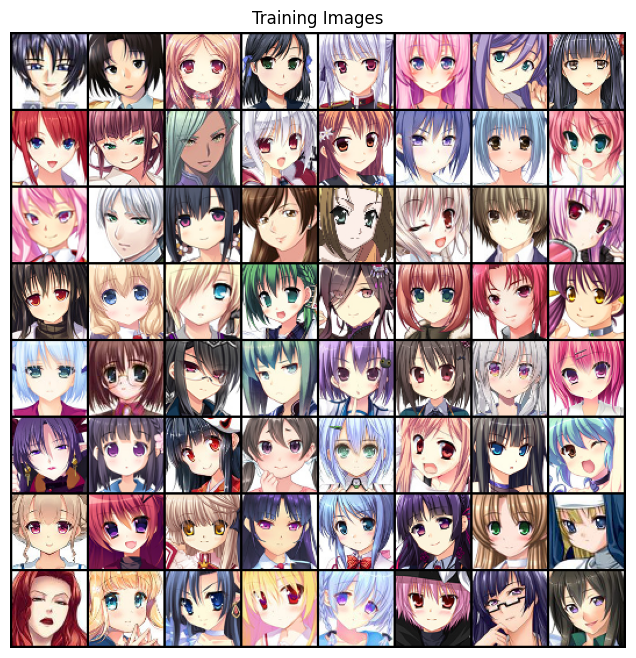

In [88]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model

Here, we use DCGAN as the model structure. Feel free to modify your own model structure.

Note that the N of the input/output shape stands for the batch size.

<br/>

### Weight Initialization


In [89]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

### Generator

In [90]:
class Generator(nn.Module):
  """
  Input shape: (N, in_dim, 1, 1)
  Output shape: (N, nc, image_size, image_size)

  In our sample code, input/output shape are:
    Input shape: (N, 100, 1, 1)
    Output shape: (N, 3, 64, 64)
  """

  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # Input is Z, going into a convolution
      nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.ReLU(True),
      # State size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.ReLU(True),
      # State size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.ReLU(True),
      # State size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf),
      nn.ReLU(True),
      # State size. (ngf) x 32 x 32
      nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # State size. (nc) x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

### Discriminator

In [91]:
class Discriminator(nn.Module):
  """
  Input shape: (N, nc, image_size, image_size)
  Output shape: (N, )

  In our sample code, input/output are:
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
  """
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # Input is (nc) x 64 x 64
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf) x 32 x 32
      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*2) x 16 x 16
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*4) x 8 x 8
      nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 8),
      nn.LeakyReLU(0.2, inplace=True),
      # State size. (ndf*8) x 4 x 4
      nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

# Train


### Initialization

In [92]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(500, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [93]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [94]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training loop

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  progress_bar = qqdm(dataloader)
  # For each batch in the dataloader
  for i, data in enumerate(progress_bar):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    # Output training stats\
    # Set the info of the progress bar
    # Note that the value of the GAN loss is not directly related to
    # the quality of the generated images.
    progress_bar.set_infos({
        'Loss_D': round(errD.item(), 4),
        'Loss_G': round(errG.item(), 4),
        'Epoch': epoch+1,
        'Step': iters,
    })


    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    iters += 1

  # Save generated image with fixed noise in each epoch
  netG.eval()
  f_imgs_sample = (netG(fixed_noise).data + 1) / 2.0
  filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
  torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
  print(f' | Save some samples to {filename}.')

  # Show generated images in the notebook and save in img_list for later use.
  grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
  img_list.append(grid_img);
  plt.figure(figsize=(10,10))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()
  netG.train()

  # Save the checkpoints.
  if (epoch+1) % 5 == 0 or epoch == 0:
    torch.save(netG.state_dict(), os.path.join(ckpt_dir, 'netG.pth'))
    torch.save(netD.state_dict(), os.path.join(ckpt_dir, 'netD.pth'))


### Plot loss

3340


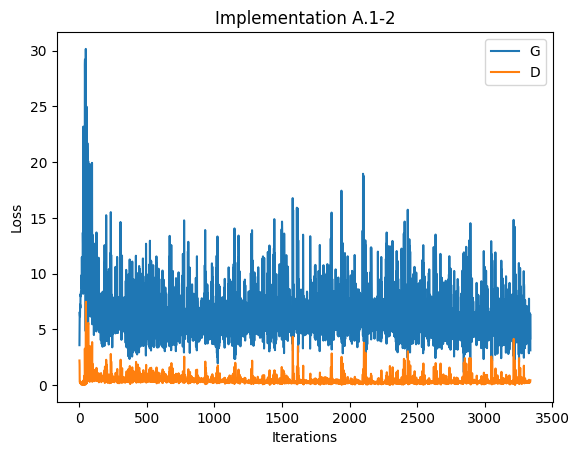

In [84]:
##########################################################################
# TODO: Plot the loss value of discriminator and generator
# Implementation A.1-2
##########################################################################
""" D & G’s losses versus training iterations. """
print(iters)
x_axis = [i for i in range(len(G_losses))]
y_axis_1 = [G_losses[i] for i in range(len(G_losses))]
y_axis_2 = [D_losses[i] for i in range(len(G_losses))]
plt.plot(x_axis, y_axis_1,label='G')
plt.plot(x_axis, y_axis_2,label='D')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Implementation A.1-2')
plt.legend()
# Display the plot
plt.savefig('A.1-2.png')

### Real Images vs. Fake Images

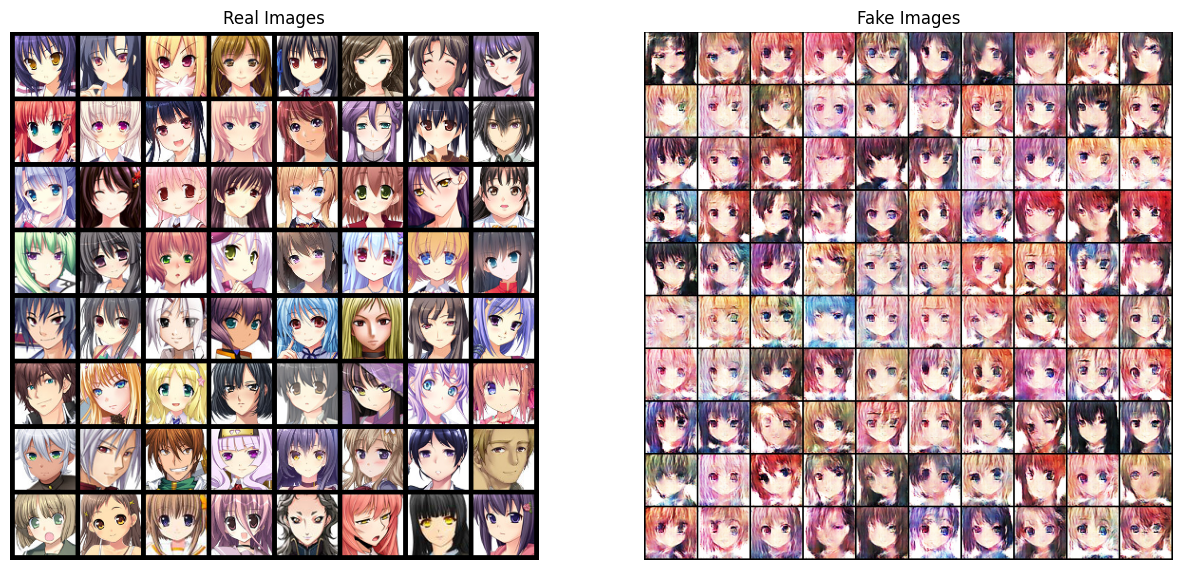

In [85]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [33]:
!ls checkpoints

netD.pth  netG.pth


# Inference

The trained model should has been saved in the directory(ckpt_dir) you specified.

Use the trained model to generate images!

### Load model


In [34]:
import torch

# load gernerator
device = torch.device("cuda")
netG = Generator(ngpu)
netG.load_state_dict(torch.load(os.path.join(ckpt_dir, 'netG.pth')))
netG.eval()
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Generate and show images

torch.Size([100, 3, 64, 64])


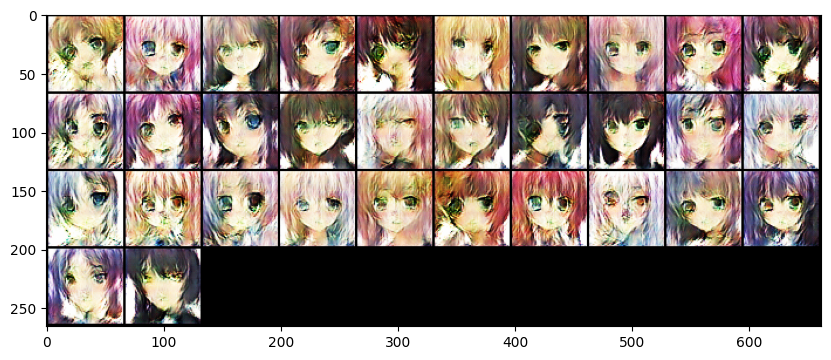

In [37]:
# Generate 100 images and make a grid to save them.
n_output = 100
fixed_noise = torch.randn(100, nz, 1, 1, device=device)
imgs_sample = (netG(fixed_noise).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images in notebook.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using tar

In [36]:
# Save the generated images in archive.
os.makedirs('output', exist_ok=True)
for i in range(n_output):
  torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')

# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/output
/content


### Plot generated images in 5*5 grid

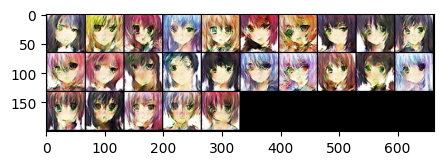

In [40]:
##########################################################################
# TODO: Store your generate images in 5*5 Grid
# Implementation A.1-3
##########################################################################
n_output = 25
fixed_noise = torch.randn(25, nz, 1, 1, device=device)
imgs_sample = (netG(fixed_noise).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'A.1-3r.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=5)


### Interpolation
Explore latent space: Interpolation 3 pairs of z vectors and plot generated images in 3*10 grid.

In [58]:
##########################################################################
# TODO: Interpolation 3 pairs of z vectors and plot a 3*10 image.
# Implementation A.1-4
##########################################################################
num = 3
result = None
for i in range(num):
  n_output = 2
  fixed_noise = torch.randn(2, nz, 1, 1, device=device)
  dis = (fixed_noise[1]-fixed_noise[0])/10
  for j in range(10):
    tmp = fixed_noise[0] + dis*j
    tmp = tmp.unsqueeze(0)
    imgs_sample = (netG(tmp).data + 1) / 2.0
    if(result == None):
      result = imgs_sample
    else:
      result = torch.cat((result, imgs_sample), dim=0)

log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'A.1-4r.jpg')
torchvision.utils.save_image(result, filename, nrow=10)

